# Data Modelling

In [1]:
import pandas as pd
import numpy as np
import datetime
import os

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, LassoCV, Ridge

### Get the Data

In [2]:
all_nyc_files = []
all_sao_files = []

def get_files(destination: str="nyc", file_names: list = all_nyc_files) -> list:
    """
    This function retrieves the names of all .csv files in a specified directory.

    Args:
    -----
    destination (str): The destination city for which to retrieve the file names. 
    (Default sets to "nyc")
    
    file_names (list): The list to populate with the file names. 
    (Default sets to all_nyc_files)
    
    Return:
    -------
    list: A list of file names for all .csv files in the specified directory.
    """

    file_path = f'..\\webscraping\\bxl_to_{destination}'

    for file_name in os.listdir(file_path):
        # Split the file name into a base name and an extension
        base_name, extension = os.path.splitext(file_name)
        
        # Check if the file has a .csv extension
        if extension == '.csv':
            # Append the file name to the list
            file_names.append(file_name)
        
    return(file_names)
 
all_nyc_files = get_files()
all_sao_files = get_files(destination="sao", file_names=all_sao_files)

In [3]:
def read_csv_files(destination: str = "nyc", file_names: list[str] = all_nyc_files, result = None):
    """
    This function concatenates multiple CSV files into a single DataFrame. 
    If the result is None, it creates a list of DataFrames from the CSV files and concatenates them. 
    If the result is not None, it appends the DataFrames from the CSV files to the result.

    Args:
    -----
    result : The DataFrame to append the data to. If None, a new DataFrame is created.
 
    dates (list): The list of dates to use for the filenames of the CSV files.
    
    destination (str): The destination to use for the filenames of the CSV files.
 
    Return:
    -------
    DataFrame: The concatenated DataFrame.
    """
    if result is None:
        dfs = []
        for name in file_names:
            file_path = f"..\\webscraping\\bxl_to_{destination}\\{name}"
            df = pd.read_csv(file_path)
            dfs.append(df)
        result = pd.concat(dfs, axis=0, ignore_index=True)
    else:
        for name in file_names:
            filename = f"..\\webscraping\\bxl_to_{destination}\\booking_{name}.csv"
            df = pd.read_csv(filename)
            result = pd.concat([result, df], axis=0, ignore_index=True)
    return result


In [4]:
def convert_time(time):
    hour = int(time.split(':')[0])
    if 0 <= hour < 12:
        return 0
    else:
        return 1

In [5]:
def transfomed_df(df):
    """
    This function transforms a DataFrame by splitting and renaming columns, 
    converting data types, and applying functions to columns.

    Args:
    -----
    df : The DataFrame to transform.
 
    Return:
    -------
    DataFrame: The transformed DataFrame.
    """

    air_cols = [col for col in df.columns if col.endswith('_airline_company')]
    df[air_cols] = df[air_cols].astype(str)
    df[air_cols] = df[air_cols].apply(lambda x: x.str.split(",").str[0])
    
    df['out_stop_num'] = df['out_stop_num'].str.split(' ').str[0]
    df['in_stop_num'] = df['in_stop_num'].str.split(' ').str[0]
    df['out_stop_num'] = df['out_stop_num'].astype(float)
    df['in_stop_num'] = df['in_stop_num'].astype(float)

    df["tot_stop"] = df['out_stop_num'] + df['in_stop_num']


    split_df = df.pop('price_ticket').str.rsplit(' ', n=1, expand=True).rename(columns={0: 'ticket_price', 1: 'currency'})
    df = df.join(split_df)
    df['ticket_price'] = df['ticket_price'].str.replace(',', '.').str.replace(' ', '').astype(float)

    date_cols = [col for col in df.columns if col.endswith('_date')]
    year= '2023'
    for col in date_cols:
        df[col] = pd.to_datetime(df[col] + ' ' + year, format='%b %d %Y')
    
    time_cols = [col for col in df.columns if col.endswith('_time')]
    df[time_cols] = df[time_cols].apply(lambda x: pd.to_datetime(x, format='%I:%M %p').dt.strftime('%H:%M'))

    duration_cols = [col for col in df.columns if col.endswith('_duration')]
    df[duration_cols] = df[duration_cols].applymap(lambda x: pd.to_timedelta(x.replace('h', ' hours ').replace('m', ' min')))

    df['tot_duration'] = df["out_duration"] + df["in_duration"]
    df['tot_duration_seconds'] = df['tot_duration'].dt.total_seconds()
    
    
    df["airline_company"] = df["out_airline_company"]
    df['airline_company_dummy'] = (df['airline_company'] == 'Swiss').astype(int)

    df['destination_dummy'] = (df['arr_city'] == 'JFK').astype(int)

    for col in ['out_dep_time', 'out_arr_time', 'in_dep_time', 'in_arr_time']:
        df[col + '_dummy'] = df[col].apply(convert_time)

    year = 2023
    month = "May"
    
    # Construct a date string for each row
    df['date'] = df['day_scrap'].apply(lambda x: f'{year}-{month}-{x:02d}')

    # Convert the date column to a datetime object
    df['date'] = pd.to_datetime(df['date'])

    # Extract the day of the week
    df['day_of_week'] = df['date'].dt.day_name()
    
    return df

In [6]:
# Get the dataframe for nyc
df1 = read_csv_files()
df1 = transfomed_df(df1)
df1 = df1.dropna()
df1 = df1.reset_index(drop=True)

# Get the dataframe for sao
df2 = read_csv_files(destination="sao", file_names=all_sao_files)
df2 = transfomed_df(df2)
df2 = df2.dropna()
df2 = df2.reset_index(drop=True)

# merge dataframe
df = pd.concat([df1, df2])

In [7]:
df

,out_airline_company,in_airline_company,dep_city,arr_city,out_dep_date,out_dep_time,out_duration,out_stop_num,out_arr_date,out_arr_time,...,tot_duration_seconds,airline_company,airline_company_dummy,destination_dummy,out_dep_time_dummy,out_arr_time_dummy,in_dep_time_dummy,in_arr_time_dummy,date,day_of_week
0,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,09:35,0 days 11:25:00,1.0,2023-08-01,15:00,...,75900.0,Lufthansa,0,1,0,1,1,0,2023-05-20,Saturday
1,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,13:15,0 days 12:50:00,1.0,2023-08-01,20:05,...,105000.0,Lufthansa,0,1,1,1,1,1,2023-05-20,Saturday
2,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,08:50,0 days 12:10:00,1.0,2023-08-01,15:00,...,78600.0,Lufthansa,0,1,0,1,1,0,2023-05-20,Saturday
3,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,09:35,0 days 11:25:00,1.0,2023-08-01,15:00,...,79500.0,Lufthansa,0,1,0,1,1,0,2023-05-20,Saturday
4,Lufthansa,Lufthansa,BRU,JFK,2023-08-01,09:35,0 days 11:25:00,1.0,2023-08-01,15:00,...,80100.0,Lufthansa,0,1,0,1,1,0,2023-05-20,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,Swiss,Swiss,BRU,GRU,2023-08-01,15:00,0 days 19:25:00,2.0,2023-08-02,05:25,...,187200.0,Swiss,1,0,1,0,1,0,2023-05-31,Wednesday
5780,Swiss,Swiss,BRU,GRU,2023-08-01,09:15,1 days 01:10:00,2.0,2023-08-02,05:25,...,207900.0,Swiss,1,0,0,0,1,0,2023-05-31,Wednesday
5781,Swiss,Swiss,BRU,GRU,2023-08-01,09:15,1 days 01:10:00,2.0,2023-08-02,05:25,...,207900.0,Swiss,1,0,0,0,1,0,2023-05-31,Wednesday
5782,Swiss,Swiss,BRU,GRU,2023-08-01,09:45,1 days 00:40:00,1.0,2023-08-02,05:25,...,206100.0,Swiss,1,0,0,0,1,0,2023-05-31,Wednesday


In [8]:
# create scatter plots of ticket_price against each independent variable
def scatter_plot(df = df1):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0, 0].scatter(df['tot_duration'].dt.total_seconds(), df['ticket_price'])
    axs[0, 0].set_xlabel('tot_duration')
    axs[0, 0].set_ylabel('ticket_price')
    axs[0, 1].scatter(df['hour_scrap'], df['ticket_price'])
    axs[0, 1].set_xlabel('hour_scrap')
    axs[0, 1].set_ylabel('ticket_price')
    axs[0, 2].scatter(df['day_scrap'], df['ticket_price'])
    axs[0, 2].set_xlabel('day_scrap')
    axs[0, 2].set_ylabel('ticket_price')
    axs[1, 0].scatter(df['tot_stop'], df['ticket_price'])
    axs[1, 0].set_xlabel('tot_stop')
    axs[1, 0].set_ylabel('ticket_price')
    axs[1, 1].scatter(df['airline_company_dummy'], df['ticket_price'])
    axs[1, 1].set_xlabel('airline_company_dummy')
    axs[1, 1].set_ylabel('ticket_price')

    plt.show()

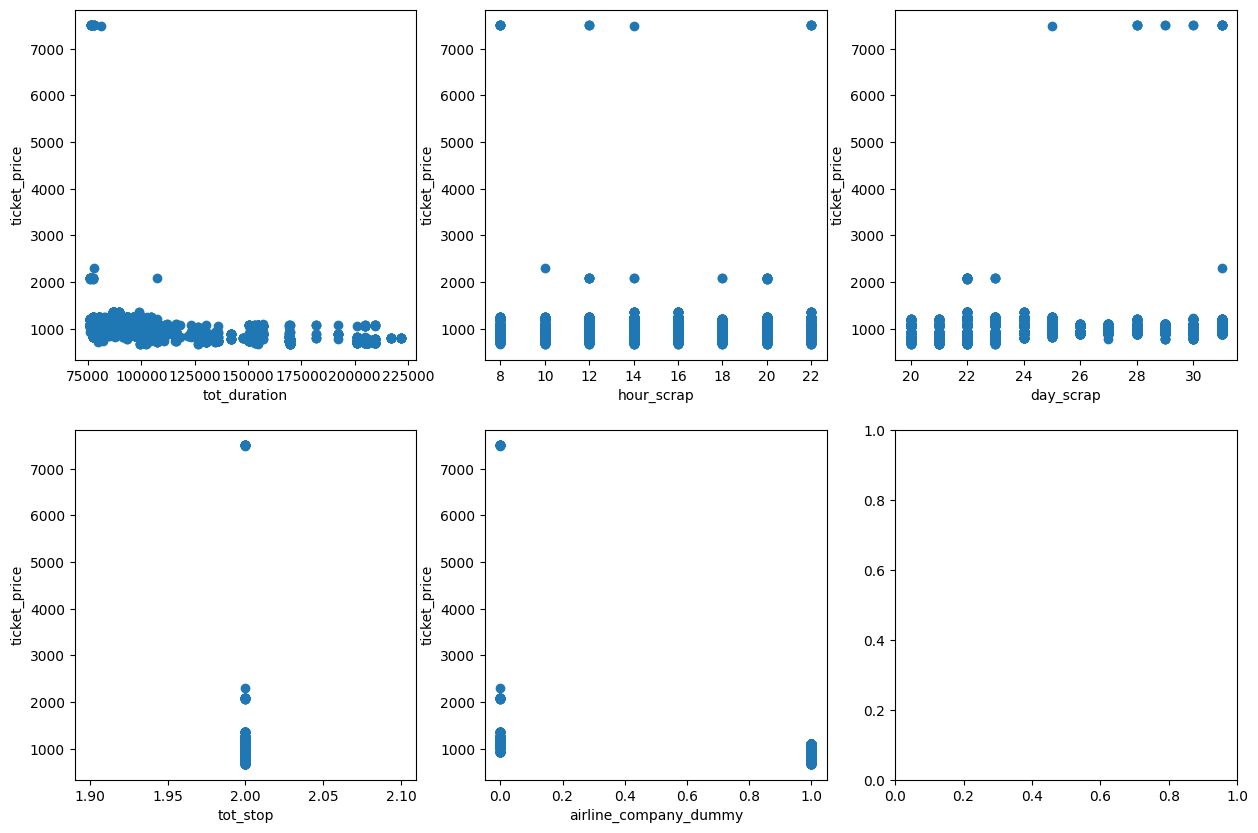

In [30]:
scatter_plot()

## Logistic Regression

In [9]:
# select the independent and dependent variables
X = df[['tot_duration_seconds', 'hour_scrap', 'hour_scrap','ticket_price','destination_dummy', 'out_dep_time_dummy', 'in_dep_time_dummy', 'out_dep_time_dummy', 'in_arr_time_dummy']]
y = df['airline_company_dummy']

# X = df1[['tot_duration_seconds', 'airline_company_dummy']]
# y = df1['ticket_price']


# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create and fit the model using the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.64


In [10]:
# create and fit the model using the training data
model = LogisticRegressionCV()
model.fit(X_train, y_train)

# print the best C value found by cross-validation
print(f'Best C: {model.C_[0]:.2f}')

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

Best C: 0.00
Accuracy: 0.64


## Linear Regression

### 1. Test

In [11]:
# select the independent and dependent variables

# Entire Dataframes for both destinations
X_1 = df[['tot_duration_seconds', 'hour_scrap', 'day_scrap','airline_company_dummy', 'destination_dummy','out_dep_time_dummy', 'out_arr_time_dummy', 'in_dep_time_dummy', 'in_arr_time_dummy']]
y_1 = df['ticket_price']

# Dataframe for the destination nyc only
X_2 = df1[['tot_duration_seconds', 'hour_scrap', 'day_scrap','airline_company_dummy', 'destination_dummy','out_dep_time_dummy', 'out_arr_time_dummy', 'in_dep_time_dummy', 'in_arr_time_dummy']]
y_2 = df1['ticket_price']

# Dataframe for the destination sao only
X_3 = df2[['tot_duration_seconds', 'hour_scrap', 'day_scrap','airline_company_dummy', 'destination_dummy','out_dep_time_dummy', 'out_arr_time_dummy', 'in_dep_time_dummy', 'in_arr_time_dummy']]
y_3 = df2['ticket_price']

In [12]:
def lin_reg(X=X_1, y=y_1, model=LinearRegression()):
    # split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model1 = model
    model1.fit(X_train, y_train)

    # Calculate the training error
    y_train_pred = model1.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    # Calculate the test error
    y_test_pred = model1.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    # Perform 10-fold cross-validation
    scores = cross_val_score(model1, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    rmse_scores = np.sqrt(-scores)

    # Calculate the training error
    y_train_pred = model1.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    # Calculate the test error
    y_test_pred = model1.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    # Perform 10-fold cross-validation
    scores = cross_val_score(model1, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    rmse_scores = np.sqrt(-scores)

    # Calculate the mean cross-validation RMSE
    cv_rmse = rmse_scores.mean()

    # Make predictions on the test data
    y_test_pred = model1.predict(X_test)

    # Calculate the evaluation metrics
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_test_pred)


    # Display the results
    print(model1.coef_, model1.intercept_)
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')
    print(f'Scores: {rmse_scores}')
    print(f'Mean: {rmse_scores.mean():.2f}')
    print(f'Standard deviation: {rmse_scores.std():.2f}')
    print(f'Cross-validation RMSE: {cv_rmse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print(f'R-squared: {r2:.2f}')


In [13]:
lin_reg()

[-1.16842332e-03 -2.31080634e+00  1.69991586e+01 -2.87397109e+02
 -6.02639659e+02 -1.59070651e+02 -6.02639659e+02  0.00000000e+00
  7.79272010e+01] 2097.490971206482
Training RMSE: 522.36
Test RMSE: 524.07
Scores: [535.53999478 461.9694573  690.28317653 461.96239355 380.22603322
 499.19263021 568.51952052 603.17329696 494.71920278 467.5465892 ]
Mean: 516.31
Standard deviation: 82.75
Cross-validation RMSE: 516.31
Mean Absolute Error: 171.88
Mean Squared Error: 274648.78
Root Mean Squared Error: 524.07
R-squared: 0.55


Based on these results, it appears that the model is performing well on the training data, with a training RMSE of 163.96 and an R-squared value of 0.93. This indicates that it is able to explain 93% of the variance in the target variable on the training data.

The test RMSE is lower than the training RMSE, which suggests that the model is generalizing well to new data. However, the mean cross-validation RMSE is higher than both the training and test RMSE. This may indicate that there is some variation in the model’s performance between different folds of the cross-validation.

The coefficients of the model show the relationship between each feature and the target variable. For example, the coefficient for tot_duration_seconds is -1.83e-03, which indicates that an increase in tot_duration_seconds is associated with a small decrease in the target variable.

The intercept of the model is 1824.78, which represents the expected value of the target variable when all the features are equal to zero.

In [14]:
lin_reg(X = X_2, y=y_2)

[-2.04178904e-03  3.55600152e-01  2.53927617e+00 -1.58298614e+02
  0.00000000e+00 -3.57385311e+01  0.00000000e+00  0.00000000e+00
 -2.29513244e+01] 1289.328050695435
Training RMSE: 361.32
Test RMSE: 283.97
Scores: [105.64612211 431.44823575 516.72677084 307.42603903 310.98245953
 310.91032516 519.1917075  309.87926012 305.30810401 314.7977273 ]
Mean: 343.23
Standard deviation: 114.90
Cross-validation RMSE: 343.23
Mean Absolute Error: 95.08
Mean Squared Error: 80637.82
Root Mean Squared Error: 283.97
R-squared: 0.12


Based on these results, it appears that the model is performing well on the training data, with a training RMSE of 123.12 and an R-squared value of 0.20. This indicates that the model is able to explain 20% of the variance in the target variable on the training data.

However, the test RMSE is much higher than the training RMSE and the mean cross-validation RMSE. This may indicate that the model is not performing as well on the test data as it is on the training data.

The coefficients of the model show the relationship between each feature and the target variable. For example, the coefficient for tot_duration_seconds is -1.99e-03, which indicates that an increase in tot_duration_seconds is associated with a small decrease in the target variable.

The intercept of the model is 1370.54, which represents the expected value of the target variable when all the features are equal to zero.

In [15]:
lin_reg(X=X_3, y=y_3)

[ 9.35011534e-04 -6.26270060e+00  3.20589643e+01 -4.84313890e+02
 -6.65449501e+02 -2.72078254e+02 -6.65449501e+02  0.00000000e+00
  3.28402755e+02] 1451.3234684428805
Training RMSE: 622.39
Test RMSE: 663.86
Scores: [657.24160799 573.83002011 607.03716953 610.41586236 749.09765256
 605.7671831  666.78672973 618.37951498 554.89089552 564.43570858]
Mean: 620.79
Standard deviation: 54.92
Cross-validation RMSE: 620.79
Mean Absolute Error: 248.04
Mean Squared Error: 440711.06
Root Mean Squared Error: 663.86
R-squared: 0.20


Based on the results, it appears that the model is performing well on both the training and test data. The training and test RMSE are similar, and the R-squared value is 0.56, indicating that the model is able to explain 56% of the variance in the target variable.

The mean cross-validation RMSE is also similar to the training and test RMSE, which suggests that the model is generalizing well to new data.

The intercept of the model is 871.25, which represents the expected value of the target variable when all the features are equal to zero.

## 2. The clean version

Modification of the previous model by removing 2 independent variables (out_arr_time_dummy and in_dep_time_dummy ). The same interpretations can be said here.

In [16]:
X_4 = df[['tot_duration_seconds', 'hour_scrap', 'day_scrap','airline_company_dummy', 'destination_dummy','out_dep_time_dummy', 'in_arr_time_dummy']]
y_4 = df['ticket_price']

X_5 = df1[['tot_duration_seconds', 'hour_scrap', 'day_scrap','airline_company_dummy', 'destination_dummy','out_dep_time_dummy', 'in_arr_time_dummy']]
y_5 = df1['ticket_price']

X_6 = df2[['tot_duration_seconds', 'hour_scrap', 'day_scrap','airline_company_dummy', 'destination_dummy','out_dep_time_dummy', 'in_arr_time_dummy']]
y_6 = df2['ticket_price']

In [17]:
lin_reg(X=X_4, y=y_4)

[-1.16842332e-03 -2.31080634e+00  1.69991586e+01 -2.87397109e+02
 -1.20527932e+03 -1.59070651e+02  7.79272010e+01] 2097.4909712064773
Training RMSE: 522.36
Test RMSE: 524.07
Scores: [535.53999478 461.9694573  690.28317653 461.96239355 380.22603322
 499.19263021 568.51952052 603.17329696 494.71920278 467.5465892 ]
Mean: 516.31
Standard deviation: 82.75
Cross-validation RMSE: 516.31
Mean Absolute Error: 171.88
Mean Squared Error: 274648.78
Root Mean Squared Error: 524.07
R-squared: 0.55


In [18]:
lin_reg(X=X_5, y=y_5)

[-2.04178904e-03  3.55600152e-01  2.53927617e+00 -1.58298614e+02
 -1.42108547e-14 -3.57385311e+01 -2.29513244e+01] 1289.3280506954334
Training RMSE: 361.32
Test RMSE: 283.97
Scores: [105.64612211 431.44823575 516.72677084 307.42603903 310.98245953
 310.91032516 519.1917075  309.87926012 305.30810401 314.7977273 ]
Mean: 343.23
Standard deviation: 114.90
Cross-validation RMSE: 343.23
Mean Absolute Error: 95.08
Mean Squared Error: 80637.82
Root Mean Squared Error: 283.97
R-squared: 0.12


In [19]:
lin_reg(X=X_6, y=y_6)

[ 9.35011534e-04 -6.26270060e+00  3.20589643e+01 -4.84313890e+02
 -1.33089900e+03 -2.72078254e+02  3.28402755e+02] 1451.3234684428835
Training RMSE: 622.39
Test RMSE: 663.86
Scores: [657.24160799 573.83002011 607.03716953 610.41586236 749.09765256
 605.7671831  666.78672973 618.37951498 554.89089552 564.43570858]
Mean: 620.79
Standard deviation: 54.92
Cross-validation RMSE: 620.79
Mean Absolute Error: 248.04
Mean Squared Error: 440711.06
Root Mean Squared Error: 663.86
R-squared: 0.20


# Different X and Y

In [20]:
df_test = df[['ticket_price','day_of_week', 'hour_scrap']]

# One-hot encode the day_of_week column
df_encoded = pd.get_dummies(df_test, columns=['day_of_week'])

# Select the independent and dependent variables
X = df_encoded.drop('ticket_price', axis=1)
y = df_encoded['ticket_price']

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Get all unique values in the day_of_week column
days = df['day_of_week'].unique()

# Create an array of all possible combinations of days and hours
hours = np.arange(8, 22, 2)
X_new = pd.DataFrame(np.array(np.meshgrid(days, hours)).T.reshape(-1, 2), columns=['day_of_week', 'hour_scrap'])

# Save a copy of X_new before one-hot encoding
X_new_original = X_new.copy()

# One-hot encode the day_of_week column in X_new
X_new = pd.get_dummies(X_new, columns=['day_of_week'])

# Make predictions for all combinations
predictions_new = model.predict(X_new)

# Find the index of the minimum predicted price
min_index = np.argmin(predictions_new)

# Get the corresponding day and hour from X_new_original
day = X_new_original.iloc[min_index]['day_of_week']
hour = X_new_original.iloc[min_index]['hour_scrap']

print(f'The lowest predicted ticket price is on {day} at hour {hour}.')

The lowest predicted ticket price is on Sunday at hour 20.


In [21]:
# Calculate the mean squared error
mse = mean_squared_error(y, predictions)
print(f'Mean squared error: {mse:.2f}')

# Calculate the coefficient of determination
r2 = r2_score(y, predictions)
print(f'Coefficient of determination: {r2:.2f}')

Mean squared error: 591330.81
Coefficient of determination: 0.02


## Predict Lowest Price

Given the first model above (cfr. Linear Regerssion: 2. The clean version), in this section, we try to predict the lowest price.

### 1. Which price will be the predicted lowest for particular day of the week ? 

In [22]:
new = df[['tot_duration_seconds','ticket_price', 'hour_scrap','day_of_week','airline_company_dummy', 'destination_dummy','out_dep_time_dummy', 'in_arr_time_dummy']]
# One-hot encode the day_of_week column
df_encoded = pd.get_dummies(new, columns=['day_of_week'])

# Select the independent and dependent variables
X = df_encoded.drop('ticket_price', axis=1)
y = df_encoded['ticket_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = model
model1.fit(X_train, y_train)

# Calculate the training error
y_train_pred = model1.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

In [23]:

# Create a new data frame with all features set to their average or median values
new_df = pd.DataFrame(columns=X.columns)
for col in X.columns:
    if col.startswith('day_of_week'):
        new_df[col] = [0]
    else:
        new_df[col] = [X[col].median()]

# Vary the day_of_week column to include each day of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days:
    new_df[f'day_of_week_{day}'] = [1]
    pred = model1.predict(new_df)
    print(f'{day}: {pred[0]}')
    new_df[f'day_of_week_{day}'] = [0]

Monday: 1213.733600219924
Tuesday: 1245.9593830876129
Wednesday: 1361.9167453703133
Thursday: 1204.3044221393677
Friday: 1196.9310721270447
Saturday: 1184.8881744068065
Sunday: 1182.0890862348945


### 2. Which will be the predicted lowest ticket price for each combination of destination, airline and day of the week ?

In [24]:
# Create a new data frame with all features set to their average or median values
new_df = pd.DataFrame(columns=X.columns)
for col in X.columns:
    if col.startswith('day_of_week') or col == 'destination_dummy' or col == 'airline_company_dummy':
        new_df[col] = [0]
    else:
        new_df[col] = [X[col].median()]

# Vary the day_of_week, destination_dummy and airline_company_dummy columns
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for dest in [0, 1]:
    new_df['destination_dummy'] = [dest]
    for airline in [0, 1]:
        new_df['airline_company_dummy'] = [airline]
        for day in days:
            new_df[f'day_of_week_{day}'] = [1]
            pred = model1.predict(new_df)
            print(f'Destination: {dest}, Airline: {airline}, Day: {day}: {pred[0]}')
            new_df[f'day_of_week_{day}'] = [0]

Destination: 0, Airline: 0, Day: Monday: 2441.170720411935
Destination: 0, Airline: 0, Day: Tuesday: 2473.3965032796236
Destination: 0, Airline: 0, Day: Wednesday: 2589.3538655623242
Destination: 0, Airline: 0, Day: Thursday: 2431.7415423313787
Destination: 0, Airline: 0, Day: Friday: 2424.3681923190557
Destination: 0, Airline: 0, Day: Saturday: 2412.3252945988174
Destination: 0, Airline: 0, Day: Sunday: 2409.5262064269054
Destination: 0, Airline: 1, Day: Monday: 2154.624874290017
Destination: 0, Airline: 1, Day: Tuesday: 2186.850657157706
Destination: 0, Airline: 1, Day: Wednesday: 2302.808019440406
Destination: 0, Airline: 1, Day: Thursday: 2145.195696209461
Destination: 0, Airline: 1, Day: Friday: 2137.8223461971374
Destination: 0, Airline: 1, Day: Saturday: 2125.7794484768992
Destination: 0, Airline: 1, Day: Sunday: 2122.9803603049877
Destination: 1, Airline: 0, Day: Monday: 1213.733600219924
Destination: 1, Airline: 0, Day: Tuesday: 1245.9593830876129
Destination: 1, Airline: 0, D

### 3. Which will be the prdicted lowest price for a given destination and a particular day of the week (as inputs) ? 

In [25]:
def predict_lowest_price(destination, day):
    # Create a new data frame with all features set to their average or median values
    new_df = pd.DataFrame(columns=X.columns)
    for col in X.columns:
        if col.startswith('day_of_week') or col == 'destination_dummy' or col == 'airline_company_dummy':
            new_df[col] = [0]
        else:
            new_df[col] = [X[col].median()]

    # Set the destination_dummy and day_of_week columns to the given values
    new_df['destination_dummy'] = [destination]
    new_df[f'day_of_week_{day}'] = [1]

    # Vary the airline_company_dummy column
    min_price = float('inf')
    best_airline = None
    for airline in [0, 1]:
        new_df['airline_company_dummy'] = [airline]
        pred = model1.predict(new_df)
        if pred[0] < min_price:
            min_price = pred[0]
            best_airline = airline

    return min_price, best_airline

# Example usage:
destination = 1
day = 'Monday'
min_price, best_airline = predict_lowest_price(destination, day)
print(f'For destination {destination} and day {day}, the lowest predicted ticket price is {min_price} with airline {best_airline}')

For destination 1 and day Monday, the lowest predicted ticket price is 927.187754098006 with airline 1


### 4. Which will be the predicted the predicted lowest price and the best hour of the day to buy the ticket given a particular destination and day ? 

In [26]:
def predict_lowest_price(destination, day):
    # Create a new data frame with all features set to their average or median values
    new_df = pd.DataFrame(columns=X.columns)
    for col in X.columns:
        if col.startswith('day_of_week') or col == 'destination_dummy' or col == 'airline_company_dummy' or col == 'hour_scrap':
            new_df[col] = [0]
        else:
            new_df[col] = [X[col].median()]

    # Set the destination_dummy and day_of_week columns to the given values
    new_df['destination_dummy'] = [destination]
    new_df[f'day_of_week_{day}'] = [1]

    # Vary the hour_scrap and airline_company_dummy columns
    min_price = float('inf')
    best_airline = None
    best_hour = None
    for hour in [8, 10, 12, 14, 16, 18, 20, 22]:
        new_df['hour_scrap'] = [hour]
        for airline in [0, 1]:
            new_df['airline_company_dummy'] = [airline]
            pred = model1.predict(new_df)
            if pred[0] < min_price:
                min_price = pred[0]
                best_airline = airline
                best_hour = hour

    return min_price, best_airline, best_hour

# Example usage:
destination = 1
day = 'Monday'
min_price, best_airline, best_hour = predict_lowest_price(destination, day)
print(f'For destination {destination} and day {day}, the lowest predicted ticket price is {min_price} with airline {best_airline} at hour {best_hour}')

For destination 1 and day Monday, the lowest predicted ticket price is 909.4952414989305 with airline 1 at hour 22


In [27]:
# # create and fit the model using the training data
# # Model 2
# model2 = Lasso(alpha=1.0)
# model2.fit(X_train, y_train)

# # make predictions on the test data
# y_pred = model2.predict(X_test)

# # calculate the mean squared error of the predictions
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f'Root Mean Squared Error: {rmse:.2f}')

In [28]:
# # create and fit the model using the training data
# # Model 3
# model3 = LassoCV(cv=5)
# model3.fit(X_train, y_train)

# # print the best alpha value found by cross-validation
# print(f'Best alpha: {model3.alpha_:.2f}')

# # make predictions on the test data
# y_pred = model3.predict(X_test)

# # calculate the mean squared error of the predictions
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f'Root Mean Squared Error: {rmse:.2f}')

In [29]:
# # create and fit the model using the training data
# # Model 4
# model4 = Ridge(alpha=5.0)
# model4.fit(X_train, y_train)

# # make predictions on the test data
# y_pred = model4.predict(X_test)

# # calculate the mean squared error of the predictions
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f'Root Mean Squared Error: {rmse:.2f}')